In [18]:
import yfinance as yf
from curl_cffi.requests.utils import SAFE_CHARS
from werkzeug.security import SALT_CHARS

df = yf.download('META', start='2023-01-01', end='2025-12-10')
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
df.to_csv('./Stock Data/METATEST.csv')

/tmp/ipykernel_1827617/1516598482.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('META', start='2023-01-01', end='2025-12-10')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: ImpersonateError('Impersonating chrome136 is not supported')


In [1]:
import pandas as pd
import os

def fetch_data(ticker):
    path = f'./Stock Data/{ticker}.csv'
    if not os.path.exists(path):
        df = yf.download(f'{ticker}', start='2022-01-01', end='2025-01-01')
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        df.to_csv(f'./Stock Data/{ticker}.csv')
    else:
        df = pd.read_csv(path)

    df = df.sort_values('Date').reset_index(drop=True)
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-9)
    df['RSI'] = 100 - (100 / (1 + rs))

    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df.dropna(inplace=True)

    eps = 1e-9
    df['Close_Norm'] = (df['Close'] - df['Close'].mean()) / (df['Close'].std() + eps)
    df['SMA_5_Norm'] = (df['SMA_5'] - df['SMA_5'].mean()) / (df['SMA_5'].std() + eps)
    df['RSI_Norm'] = (df['RSI'] - df['RSI'].mean()) / (df['RSI'].std() + eps)
    df['MACD_Norm'] = (df['MACD'] - df['MACD'].mean()) / (df['MACD'].std() + eps)

    return df.reset_index(drop=True)

In [2]:
import matplotlib.pyplot as plt

def plot(df):
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Stock Close Price')
    plt.legend()
    plt.show()

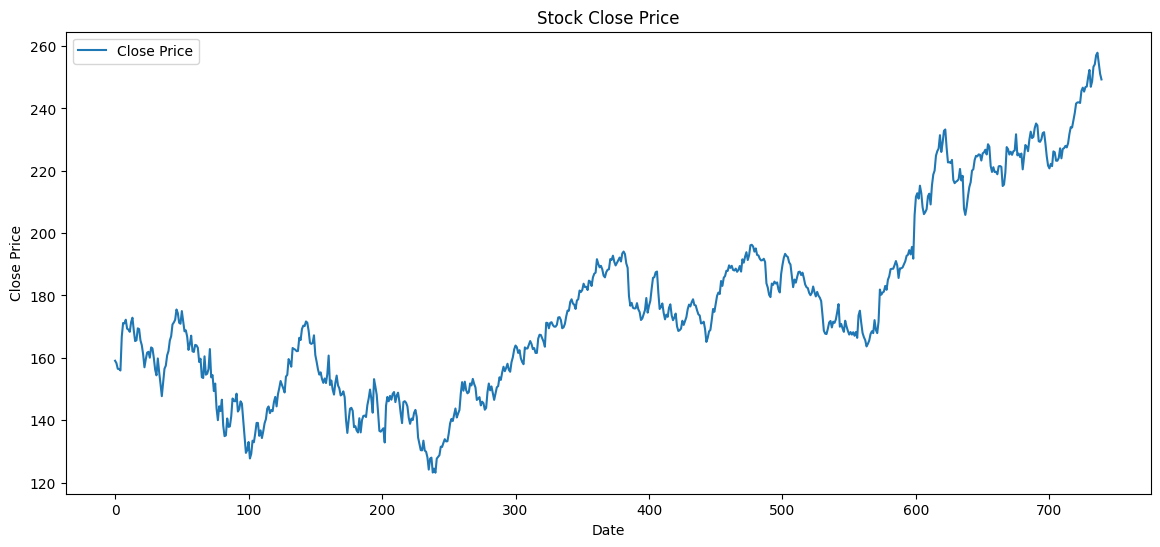

,Date,Close,High,Low,Open,Volume,SMA_5,SMA_10,RSI,MACD,Signal_Line,Close_Norm,SMA_5_Norm,RSI_Norm,MACD_Norm
0,2022-01-21,159.073029,162.912484,158.965288,161.041724,122848900,163.768539,166.818550,15.517377,-4.036910,-2.738770,-0.579471,-0.418724,-2.103448,-1.507185
1,2022-01-24,158.299286,158.965322,151.521469,156.732169,162294600,161.525586,165.785233,15.097716,-4.434675,-3.077951,-0.605482,-0.495057,-2.126654,-1.635535
2,2022-01-25,156.497070,159.415837,153.793784,155.713505,115798400,159.562766,164.569730,15.344590,-4.839542,-3.430269,-0.666066,-0.561856,-2.113003,-1.766177
3,2022-01-26,156.408936,161.012364,154.577362,160.140651,108275300,158.281641,163.062355,18.336959,-5.108626,-3.765941,-0.669029,-0.605455,-1.947533,-1.853004
4,2022-01-27,155.948593,160.473664,155.027904,159.112224,121954600,157.245383,161.464868,20.416849,-5.297950,-4.072343,-0.684504,-0.640721,-1.832520,-1.914095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2024-12-24,257.037476,257.047410,254.140559,254.339671,23234700,252.020166,250.158592,76.180696,6.046646,5.371806,2.713751,2.584663,1.251073,1.746554
736,2024-12-26,257.853760,258.928914,256.470034,257.027510,27237100,254.204282,251.405946,76.812146,6.278545,5.553154,2.741192,2.658993,1.285991,1.821383
737,2024-12-27,254.439224,257.535238,251.920617,256.669129,42355300,255.359061,252.165509,69.300678,6.116298,5.665783,2.626407,2.698293,0.870626,1.769030
738,2024-12-30,251.064484,252.358634,249.621015,251.094347,35557500,254.903122,252.570674,58.382057,5.650269,5.662680,2.512960,2.682776,0.266855,1.618653


In [3]:
aapl = fetch_data('AAPL')
plot(aapl)
aapl

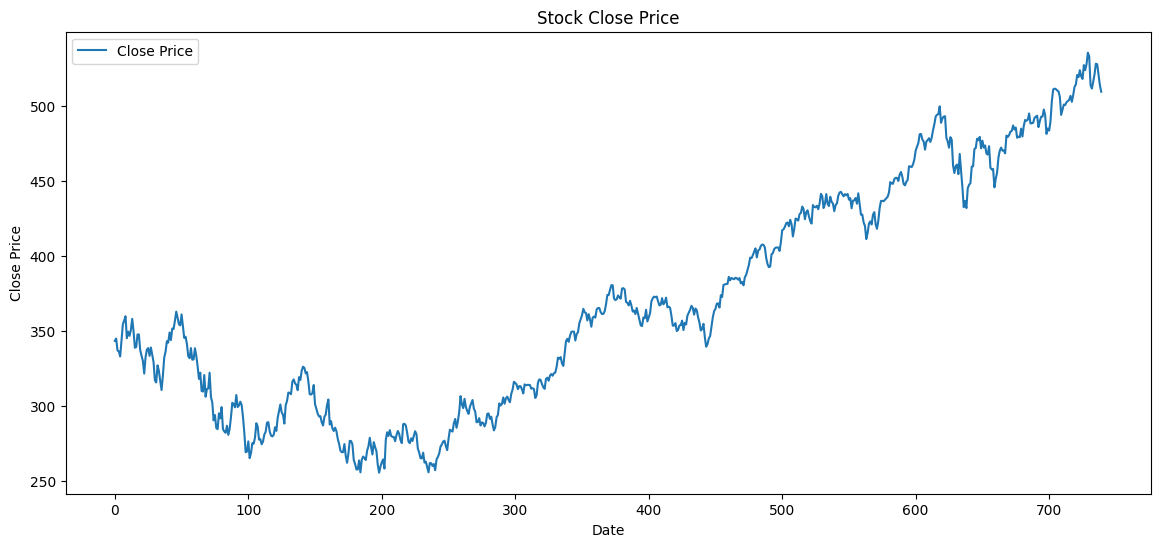

,Date,Close,High,Low,Open,Volume,SMA_5,SMA_10,RSI,MACD,Signal_Line,Close_Norm,SMA_5_Norm,RSI_Norm,MACD_Norm
0,2022-01-21,343.375824,353.617824,343.092671,350.971899,143388900,357.435437,365.280499,14.123828,-9.739632,-6.397762,-0.336156,-0.146971,-2.448895,-2.028353
1,2022-01-24,344.947815,345.611762,326.250536,337.732533,198685800,352.219727,362.687289,16.063567,-10.666738,-7.251557,-0.315514,-0.215928,-2.331680,-2.199826
2,2022-01-25,336.951508,342.731571,333.602601,338.474656,124398400,347.252032,359.270038,15.418958,-11.909427,-8.183131,-0.420516,-0.281606,-2.370633,-2.429668
3,2022-01-26,336.424225,348.443209,332.723814,344.567060,146559500,342.973633,355.242557,18.285055,-12.789386,-9.104382,-0.427440,-0.338171,-2.197440,-2.592421
4,2022-01-27,333.036285,342.965846,332.011090,341.140059,95255700,338.947131,350.726892,17.396109,-13.603327,-10.004171,-0.471929,-0.391405,-2.251157,-2.742964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2024-12-24,527.965210,528.054837,522.216909,522.854515,17558200,517.970093,523.648657,54.902086,5.127301,5.977332,2.087758,1.975458,0.015262,0.721363
736,2024-12-26,527.606506,529.240348,524.328912,526.331356,19090500,520.751880,523.701770,55.689425,5.280540,5.837974,2.083048,2.012236,0.062840,0.749705
737,2024-12-27,520.593018,524.468390,515.910697,524.030044,33839600,522.588489,523.393701,48.036017,4.780941,5.626567,1.990951,2.036518,-0.399642,0.657301
738,2024-12-30,513.669189,517.405074,509.903419,513.569590,34584000,522.147156,521.992407,46.343572,3.782706,5.257795,1.900032,2.030683,-0.501914,0.472673


In [4]:
qqq = fetch_data('QQQ')
plot(qqq)
qqq

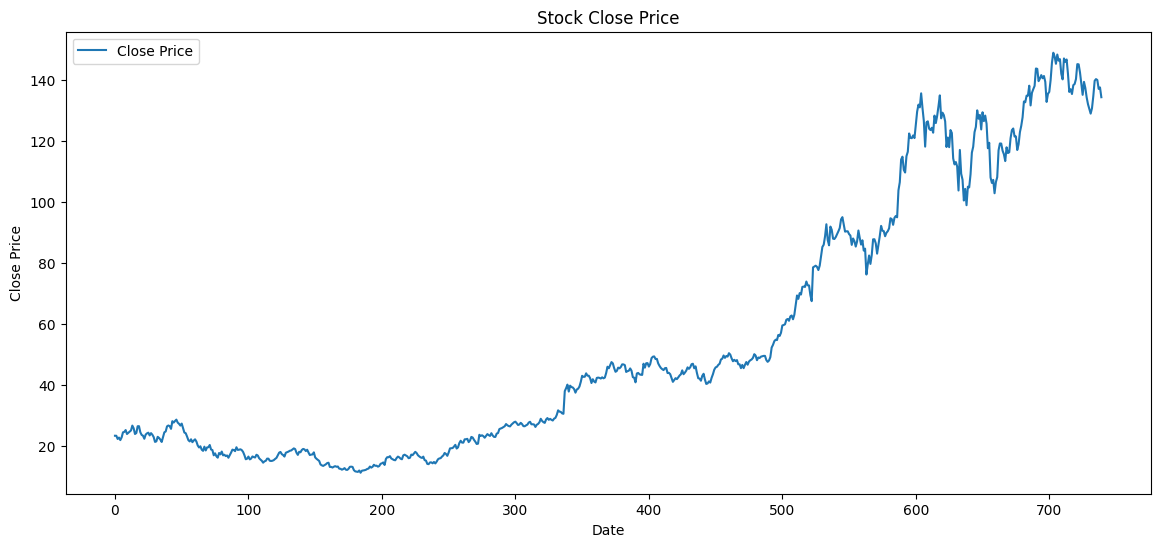

,Date,Close,High,Low,Open,Volume,SMA_5,SMA_10,RSI,MACD,Signal_Line,Close_Norm,SMA_5_Norm,RSI_Norm,MACD_Norm
0,2022-01-21,23.328812,24.775010,23.218026,23.461554,718958000,25.038698,26.196655,16.707759,-1.407814,-0.923236,-0.744006,-0.700333,-2.211878,-1.083050
1,2022-01-24,23.326817,23.334801,20.847619,22.286831,913982000,24.326079,25.809904,16.704463,-1.536271,-1.045843,-0.744053,-0.717239,-2.212068,-1.140119
2,2022-01-25,22.280840,22.898645,21.957467,22.502411,664616000,23.611663,25.303285,16.354294,-1.702846,-1.177244,-0.768735,-0.734188,-2.232237,-1.214123
3,2022-01-26,22.727972,24.010487,22.256884,23.195068,755959000,23.153550,24.799760,23.491278,-1.778279,-1.297451,-0.758184,-0.745056,-1.821172,-1.247635
4,2022-01-27,21.901575,23.948610,21.633094,23.522436,573353000,22.713203,24.195431,16.727128,-1.883037,-1.414568,-0.777684,-0.755503,-2.210763,-1.294176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2024-12-24,140.181656,141.861189,138.612078,139.961715,105157000,134.799121,134.710147,43.182439,-1.154466,-1.313275,2.013299,1.903644,-0.687030,-0.970495
736,2024-12-26,139.891739,140.811501,137.692343,139.661806,116205600,137.002518,134.772131,42.920220,-0.773582,-1.205337,2.006458,1.955918,-0.702133,-0.801280
737,2024-12-27,136.972519,138.981979,134.673160,138.512106,170582600,138.268173,134.739139,42.567713,-0.699225,-1.104114,1.937575,1.985945,-0.722436,-0.768246
738,2024-12-30,137.452393,140.231631,133.983341,134.793117,167734700,138.826019,135.063049,48.022764,-0.594719,-1.002235,1.948899,1.999179,-0.408245,-0.721817


In [5]:
nvda = fetch_data('NVDA')
plot(nvda)
nvda

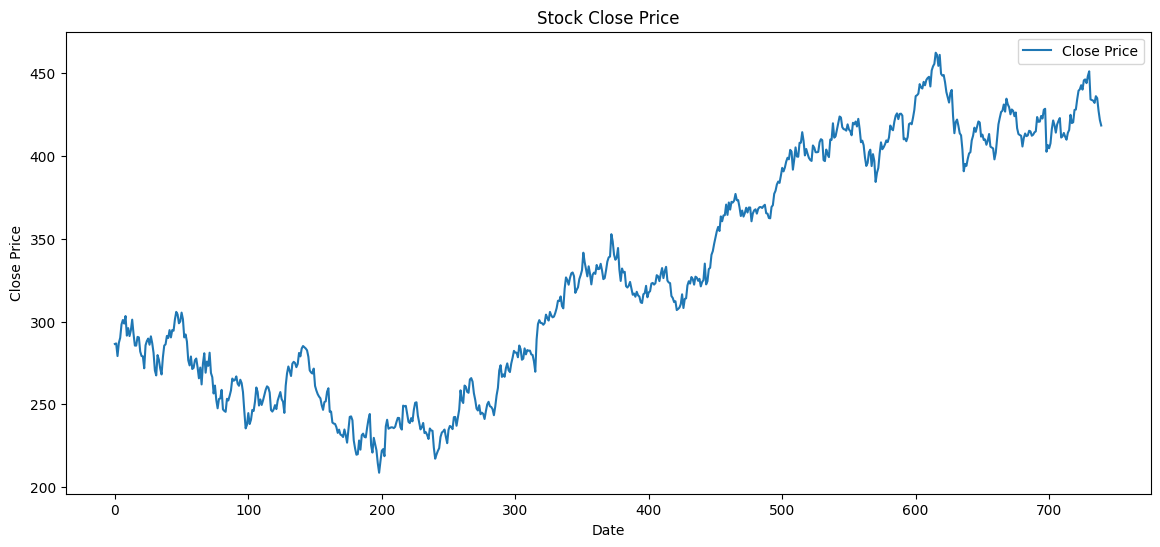

,Date,Close,High,Low,Open,Volume,SMA_5,SMA_10,RSI,MACD,Signal_Line,Close_Norm,SMA_5_Norm,RSI_Norm,MACD_Norm
0,2022-01-21,286.433533,294.251589,286.027135,292.877638,57984400,292.947321,298.031979,17.549246,-8.411940,-6.281792,-0.593673,-0.499847,-2.221188,-1.907877
1,2022-01-24,286.762543,287.478545,267.101251,282.727739,85731500,290.270990,296.322260,18.016514,-8.802723,-6.785978,-0.589079,-0.537366,-2.191939,-1.986366
2,2022-01-25,279.137970,285.427259,275.925617,282.069745,72848600,287.530786,293.827823,17.396056,-9.616804,-7.352144,-0.695537,-0.575781,-2.230777,-2.149873
3,2022-01-26,287.091492,298.499301,283.530794,298.005825,90428900,286.249713,292.060046,32.963662,-9.510555,-7.783826,-0.584486,-0.593740,-1.256317,-2.128533
4,2022-01-27,290.120087,297.338248,288.272000,292.848678,53481300,285.909125,290.276797,37.971197,-9.077331,-8.042527,-0.542200,-0.598515,-0.942869,-2.041520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2024-12-24,436.112854,436.380896,431.010509,431.467132,7164500,433.919067,440.497537,51.898968,4.095947,5.566190,1.496222,1.476413,-0.071055,0.604315
736,2024-12-26,434.901794,437.711088,433.432652,435.864693,8194200,434.062012,439.417502,45.130625,3.638926,5.180737,1.479313,1.478417,-0.494722,0.512523
737,2024-12-27,427.377319,432.032978,423.227936,431.417523,18117700,432.771527,437.528436,37.684157,2.639149,4.672420,1.374253,1.460326,-0.960836,0.311719
738,2024-12-30,421.719025,424.419108,418.810488,422.940028,13158700,430.434747,435.300867,31.144324,1.374398,4.012816,1.295249,1.427567,-1.370199,0.057696


In [6]:
msft = fetch_data('MSFT')
plot(msft)
msft

In [7]:
class TradingEnv:
    def __init__(self, df, initial_balance=10000, window=200, max_units=1000):
        self.df = df.reset_index(drop=True)
        self.initial_balance = float(initial_balance)
        self.window = int(window)
        self.max_units = int(max_units)
        self.states = ['Close_Norm', 'SMA_5_Norm', 'RSI_Norm', 'MACD_Norm']
        self.reset()
        self.state_size = len(self.get_state())
        self.action_space = 3

    def reset(self, deterministic=False):
        self.start = 0 if deterministic else random.randint(0, max(0, len(self.df) - self.window - 1))
        self.current_step = self.start
        self.end = min(len(self.df) - 1, self.start + self.window)
        self.balance = float(self.initial_balance)
        self.inventory = []
        self.total_profit = 0.0
        self.prev_equity = self.initial_balance
        self.done = False
        return self.get_state()

    def get_state(self):
        base = self.df.loc[self.current_step, self.states].values.astype(np.float32)
        pos_qty = sum(q for _, q in self.inventory)
        price = float(self.df.loc[self.current_step, 'Close'])
        equity = self.get_equity(price)
        pos_val = (pos_qty * price) / (equity + 1e-9)
        cash_frac = self.balance / (equity + 1e-9)
        return np.concatenate([base, [pos_val, cash_frac]])

    def get_equity(self, price):
        return self.balance + sum(q * price for _, q in self.inventory)

    def step(self, action):
        price = float(self.df.loc[self.current_step, 'Close'])
        reward = 0.0

        if action == 1:
            affordable = int(self.balance // price)
            if affordable > 0:
                buy_qty = max(1, int(min(affordable * 0.35, self.max_units)))
                self.inventory.append([price, buy_qty])
                self.balance -= price * buy_qty
            else:
                reward -= 0.1

        elif action == 2:
            if self.inventory:
                buy_price, qty = self.inventory.pop(0)
                revenue = price * qty
                profit = revenue - (buy_price * qty)
                self.balance += revenue
                self.total_profit += profit
                reward += profit
            else:
                reward -= 0.1

        self.current_step += 1

        if self.current_step >= self.end:
            final_price = float(self.df.loc[self.current_step, 'Close'])
            if self.inventory:
                total_qty = sum(q for _, q in self.inventory)
                total_cost = sum(bp * q for bp, q in self.inventory)
                revenue = total_qty * final_price
                self.balance += revenue
                self.total_profit += revenue - total_cost
                self.inventory = []
            self.done = True

        next_price = float(self.df.loc[self.current_step, 'Close'])
        equity = self.get_equity(next_price)
        eq_diff = equity - self.prev_equity

        reward += eq_diff * 0.035

        pos_value = sum(q for _, q in self.inventory) * next_price
        reward -= 0.0002 * pos_value

        if self.inventory:
            reward += 0.002 * eq_diff

        self.prev_equity = equity
        return self.get_state(), float(reward), self.done, self.total_profit


In [8]:
os.environ["TF_NUM_INTRAOP_THREADS"] = "0"
os.environ["TF_NUM_INTEROP_THREADS"] = "0"

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class SAC:
    def __init__(self, state_dim, action_dim, gamma=0.99, tau=0.005, lr=3e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau

        self.log_alpha = tf.Variable(0.0, dtype=tf.float32)
        self.alpha = tf.Variable(tf.exp(self.log_alpha), dtype=tf.float32)
        self.target_entropy = -np.log(1.0 / action_dim)

        self.actor = self.build_actor()
        self.q1 = self.build_critic()
        self.q2 = self.build_critic()
        self.tq1 = self.build_critic()
        self.tq2 = self.build_critic()

        self.tq1.set_weights(self.q1.get_weights())
        self.tq2.set_weights(self.q2.get_weights())

        self.actor_opt = Adam(lr)
        self.critic_opt = Adam(lr)
        self.alpha_opt = Adam(lr)

    def build_actor(self):
        s = Input((self.state_dim,))
        x = Dense(256, activation='relu')(s)
        x = Dense(256, activation='relu')(x)
        a = Dense(self.action_dim)(x)
        return Model(s, a)

    def build_critic(self):
        s = Input((self.state_dim,))
        x = Dense(256, activation='relu')(s)
        x = Dense(256, activation='relu')(x)
        q = Dense(self.action_dim)(x)
        return Model(s, q)

    def sample_action(self, state):
        logits = self.actor(state.reshape(1,-1))
        probs = tf.nn.softmax(logits)[0].numpy()
        return int(np.random.choice(self.action_dim, p=probs))

    def train(self, buffer, batch=64):
        if len(buffer) < batch:
            return

        s,a,r,ns,d = zip(*random.sample(buffer, batch))
        s = tf.convert_to_tensor(s, tf.float32)
        ns = tf.convert_to_tensor(ns, tf.float32)
        a = tf.convert_to_tensor(a, tf.int32)
        r = tf.convert_to_tensor(r, tf.float32)
        d = tf.convert_to_tensor(d, tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            q1 = tf.reduce_sum(self.q1(s) * tf.one_hot(a,self.action_dim), axis=1)
            q2 = tf.reduce_sum(self.q2(s) * tf.one_hot(a,self.action_dim), axis=1)

            n_logits = self.actor(ns)
            n_probs = tf.nn.softmax(n_logits)
            n_logp = tf.nn.log_softmax(n_logits)

            tq1 = self.tq1(ns)
            tq2 = self.tq2(ns)
            min_tq = tf.minimum(tq1, tq2)

            v = tf.reduce_sum(n_probs * (min_tq - self.alpha * n_logp), axis=1)
            target = r + self.gamma * (1 - d) * v

            closs = tf.reduce_mean((q1 - target)**2 + (q2 - target)**2)

            logits = self.actor(s)
            probs = tf.nn.softmax(logits)
            logp = tf.nn.log_softmax(logits)

            q_pi = tf.minimum(self.q1(s), self.q2(s))
            aloss = tf.reduce_mean(tf.reduce_sum(probs * (self.alpha * logp - q_pi), axis=1))

            entropy = -tf.reduce_sum(probs * logp, axis=1)
            alpha_loss = -tf.reduce_mean(self.log_alpha * (entropy - self.target_entropy))

        self.critic_opt.apply_gradients(zip(tape.gradient(closs, self.q1.trainable_variables + self.q2.trainable_variables),
                                            self.q1.trainable_variables + self.q2.trainable_variables))
        self.actor_opt.apply_gradients(zip(tape.gradient(aloss, self.actor.trainable_variables),
                                           self.actor.trainable_variables))
        self.alpha_opt.apply_gradients(zip(tape.gradient(alpha_loss, [self.log_alpha]), [self.log_alpha]))

        self.alpha.assign(tf.exp(self.log_alpha))

        for w,t in zip(self.q1.weights, self.tq1.weights):
            t.assign(self.tau*w + (1-self.tau)*t)
        for w,t in zip(self.q2.weights, self.tq2.weights):
            t.assign(self.tau*w + (1-self.tau)*t)

2025-12-20 18:47:14.720928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-20 18:47:15.688646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-20 18:47:18.855745: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
def train(envs, tickers, episodes=200, buffer_limit=200000):
    env = envs[tickers[0]]
    agent = SAC(env.state_size, 3)
    buffer = []

    for ep in range(episodes):
        env = envs[tickers[ep % len(tickers)]]
        s = env.reset()
        done = False

        while not done:
            a = agent.sample_action(s)
            ns, r, done, _ = env.step(a)

            buffer.append((s, a, r, ns, float(done)))
            if len(buffer) > buffer_limit:
                buffer.pop(0)

            s = ns
            agent.train(buffer)

        print("Episode", ep, "Profit", env.total_profit)

    return agent

In [10]:
def evaluate(ticker, actor):
    df = fetch_data(ticker)
    env = TradingEnv(df, window=len(df) - 1)

    state = env.reset(deterministic=True)
    done = False
    signals = []

    while not done:
        logits = actor(state.reshape(1, -1))
        action = int(tf.argmax(logits[0]).numpy())
        signals.append(action)
        state, _, done, _ = env.step(action)

    if len(signals) < len(df):
        signals.extend([0] * (len(df) - len(signals)))

    df_out = df.copy()
    df_out['Signal'] = signals[:len(df)]
    df_out['Signal_Label'] = df_out['Signal'].map({0: 'HOLD', 1: 'BUY', 2: 'SELL'})

    balance = float(env.initial_balance)
    executed = []

    for _, row in df_out.iterrows():
        price = float(row['Close'])
        signal = int(row['Signal'])

        if signal == 1:
            if balance >= price:
                executed.append(1)
                balance -= price
            else:
                executed.append(0)
        elif signal == 2:
            executed.append(2)
            balance += price
        else:
            executed.append(0)

    df_out['Signal'] = executed
    df_out['Signal_Label'] = df_out['Signal'].map(
        {0: 'HOLD', 1: 'BUY', 2: 'SELL'}
    )

    buy_idx = df_out.index[df_out['Signal'] == 1]
    sell_idx = df_out.index[df_out['Signal'] == 2]

    plt.figure(figsize=(14, 6))
    plt.plot(df_out['Close'].values, label='Close Price')
    plt.scatter(buy_idx, df_out.loc[buy_idx, 'Close'], marker='^', s=80)
    plt.scatter(sell_idx, df_out.loc[sell_idx, 'Close'], marker='v', s=80)
    plt.title(f"{ticker} — Price with Executed BUY / SELL Signals")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    final_balance = env.balance
    final_profit = final_balance - env.initial_balance

    return df_out, final_profit, final_balance

In [11]:
def test(ticker, actor):
    df, profit, balance = evaluate(f"{ticker}", actor)
    print(f"Final realized profit ({ticker}):", profit)
    print("Final balance:", balance)
    print("Total BUYs:", (df['Signal'] == 1).sum())
    print("Total SELLs:", (df['Signal'] == 2).sum())
    print("Total HOLDs:", (df['Signal'] == 0).sum())
    print(df[['Close', 'Signal', 'Signal_Label']].head(40))

In [25]:
tickers = ["QQQ","AAPL","MSFT","NVDA"]
envs = {t:TradingEnv(fetch_data(t)) for t in tickers}

In [26]:
agent = train(envs, tickers)

Episode 0 Profit 1181.731262207032
Episode 1 Profit 1048.7787475585938
Episode 2 Profit 669.4262390136718
Episode 3 Profit -3845.7001762390128
Episode 4 Profit 2684.8282775878915
Episode 5 Profit 1224.4093322753915
Episode 6 Profit 1221.687683105471
Episode 7 Profit 13731.044292449955
Episode 8 Profit 150.25180053710938
Episode 9 Profit 1168.8269348144538
Episode 10 Profit 305.84564208984426
Episode 11 Profit 2602.1032304763794
Episode 12 Profit 2434.669677734374
Episode 13 Profit 431.80482482910134
Episode 14 Profit 724.0950927734395
Episode 15 Profit 13007.278737068176
Episode 16 Profit 2078.628784179689
Episode 17 Profit 1038.8461914062489
Episode 18 Profit 994.7725830078123
Episode 19 Profit 9323.420675277706
Episode 20 Profit 2483.4232177734375
Episode 21 Profit 597.8024139404283
Episode 22 Profit 1191.006011962891
Episode 23 Profit 7375.1441078186035
Episode 24 Profit 1466.2404785156252
Episode 25 Profit -1445.4726104736328
Episode 26 Profit 3867.565719604492
Episode 27 Profit 31

In [47]:
#agent.actor.save("models/tech_stocks.keras")

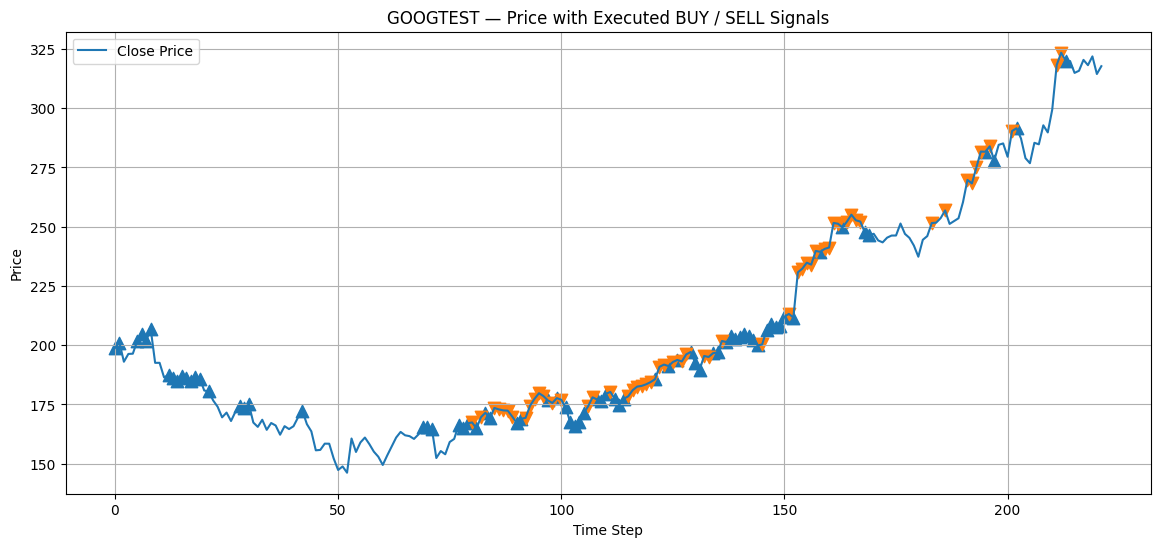

Final realized profit (GOOGTEST): 3728.455307006836
Final balance: 13728.455307006836
Total BUYs: 73
Total SELLs: 56
Total HOLDs: 93
         Close  Signal Signal_Label
0   198.806046       1          BUY
1   201.117035       1          BUY
2   193.018585       0         HOLD
3   196.305771       0         HOLD
4   196.415344       0         HOLD
5   201.844208       1          BUY
6   204.802704       1          BUY
7   201.854156       1          BUY
8   206.904510       1          BUY
9   192.550385       0         HOLD
10  192.560349       0         HOLD
11  186.414276       0         HOLD
12  187.470154       1          BUY
13  186.344574       1          BUY
14  184.710907       1          BUY
15  187.151398       1          BUY
16  186.145309       1          BUY
17  185.079468       1          BUY
18  186.404312       1          BUY
19  185.916214       1          BUY
20  180.875839       0         HOLD
21  180.487350       1          BUY
22  176.682175       0         HOLD
23 

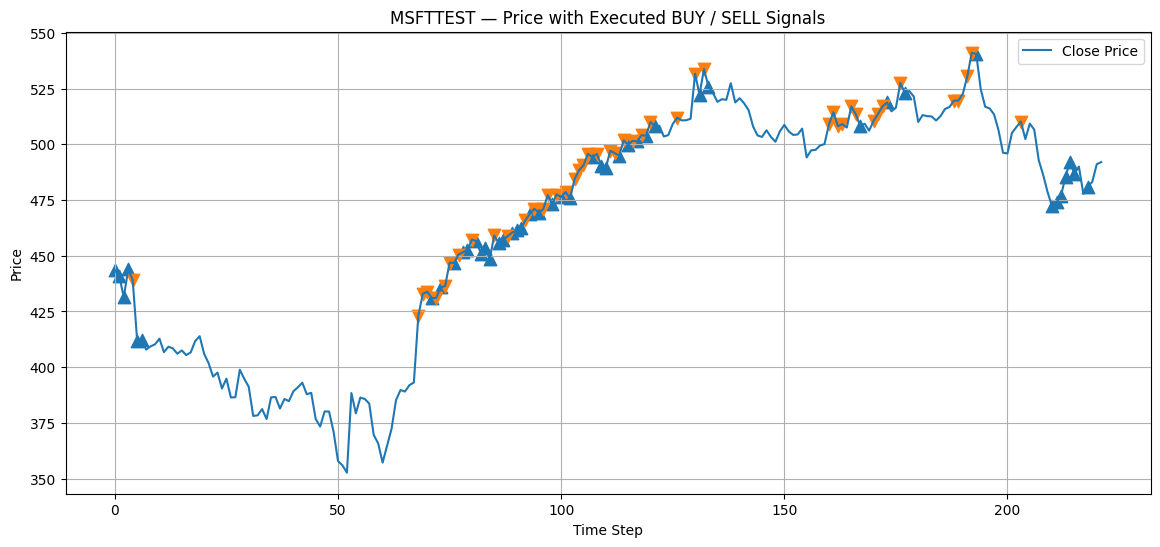

Final realized profit (MSFTTEST): 1378.1393432617188
Final balance: 11378.139343261719
Total BUYs: 46
Total SELLs: 46
Total HOLDs: 130
         Close  Signal Signal_Label
0   443.438812       1          BUY
1   440.808258       1          BUY
2   431.377838       1          BUY
3   443.925262       1          BUY
4   439.090912       2         SELL
5   411.951111       1          BUY
6   412.020599       1          BUY
7   407.910919       0         HOLD
8   409.350311       0         HOLD
9   410.263611       0         HOLD
10  412.775024       0         HOLD
11  406.749481       0         HOLD
12  409.201416       0         HOLD
13  408.427094       0         HOLD
14  406.044708       0         HOLD
15  407.533691       0         HOLD
16  405.439148       0         HOLD
17  406.640320       0         HOLD
18  411.732727       0         HOLD
19  413.911072       0         HOLD
20  406.033264       0         HOLD
21  401.845734       0         HOLD
22  395.778259       0         HOLD
2

In [23]:
actor = tf.keras.models.load_model("models/tech_stocks.keras") #higher short term profit

test("GOOGTEST", actor)
test("MSFTTEST", actor)

In [69]:
tickers = ["AMZN", "SHOP", "EBAY", "ETSY"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [70]:
agent = train(envs, tickers)

Episode 0 Profit 947.6298065185526
Episode 1 Profit 192.7599716186528
Episode 2 Profit -1356.1956024169913
Episode 3 Profit -451.5150566101074
Episode 4 Profit 525.659965515136
Episode 5 Profit 19219.42130279541
Episode 6 Profit 1600.7276420593262
Episode 7 Profit 3261.3801040649414
Episode 8 Profit 3203.881240844723
Episode 9 Profit 1102.8305587768555
Episode 10 Profit 231.74507904052751
Episode 11 Profit -2033.280029296875
Episode 12 Profit 5424.0482330322275
Episode 13 Profit 1778.2411422729492
Episode 14 Profit 3759.296314239501
Episode 15 Profit -8.655006408691406
Episode 16 Profit 6228.259193420412
Episode 17 Profit 623.2398643493634
Episode 18 Profit -1945.2089843749995
Episode 19 Profit -676.1954383850098
Episode 20 Profit 3656.170440673828
Episode 21 Profit 6806.941074371338
Episode 22 Profit 1994.5151100158673
Episode 23 Profit -1520.2646484375014
Episode 24 Profit -1137.3908386230505
Episode 25 Profit 8642.679481506348
Episode 26 Profit 3042.8429412841815
Episode 27 Profit -

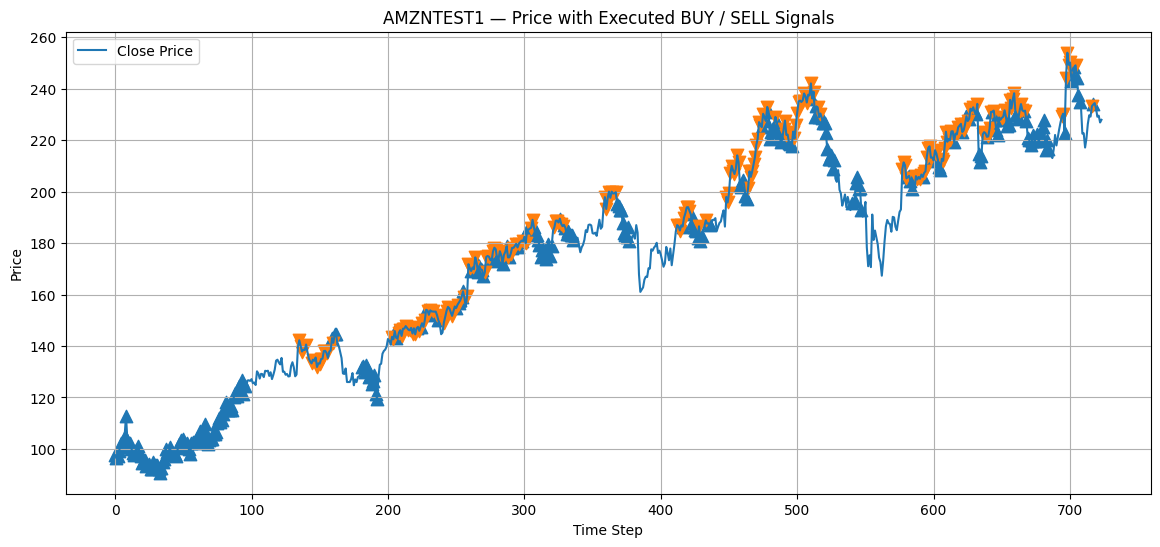

Final realized profit (AMZNTEST1): 10581.030380249023
Final balance: 20581.030380249023
Total BUYs: 297
Total SELLs: 202
Total HOLDs: 225
         Close  Signal Signal_Label
0    97.519997       1          BUY
1    96.320000       1          BUY
2    97.180000       1          BUY
3    99.220001       1          BUY
4   102.239998       1          BUY
5   100.550003       1          BUY
6   103.129997       1          BUY
7   105.150002       1          BUY
8   112.910004       1          BUY
9   103.389999       1          BUY
10  102.180000       1          BUY
11  102.110001       1          BUY
12  100.050003       1          BUY
13   98.239998       1          BUY
14   97.610001       1          BUY
15   99.540001       1          BUY
16   99.699997       1          BUY
17  101.160004       1          BUY
18   98.150002       1          BUY
19   97.199997       1          BUY
20   94.580002       1          BUY
21   95.790001       1          BUY
22   95.820000       1          BU

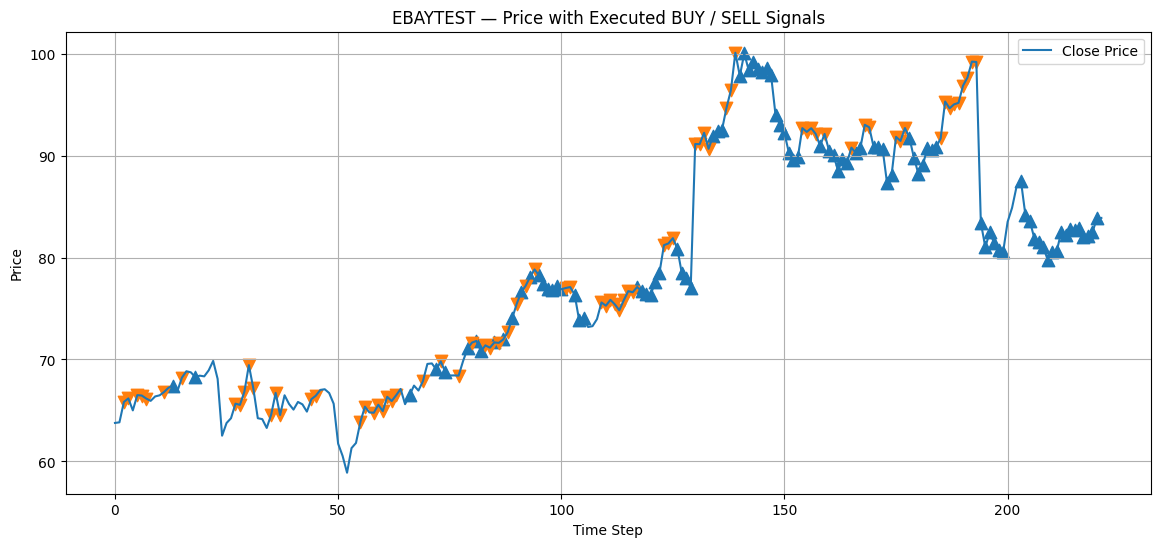

Final realized profit (EBAYTEST): 2208.2545471191406
Final balance: 12208.25454711914
Total BUYs: 93
Total SELLs: 76
Total HOLDs: 53
        Close  Signal Signal_Label
0   63.775139       0         HOLD
1   63.834236       0         HOLD
2   65.833664       2         SELL
3   66.178413       2         SELL
4   65.006310       0         HOLD
5   66.503433       2         SELL
6   66.464035       2         SELL
7   66.168556       2         SELL
8   65.942017       0         HOLD
9   66.375389       0         HOLD
10  66.483734       0         HOLD
11  66.808762       2         SELL
12  67.232285       0         HOLD
13  67.429276       1          BUY
14  66.917122       0         HOLD
15  68.217239       2         SELL
16  68.847595       0         HOLD
17  68.739258       0         HOLD
18  68.276337       1          BUY
19  68.414223       0         HOLD
20  68.345276       0         HOLD
21  68.936241       0         HOLD
22  69.862099       0         HOLD
23  68.099045       0      

In [24]:
actor = tf.keras.models.load_model("models/ecom_stocks.keras")

test("AMZNTEST1", actor)
test("EBAYTEST", actor)

In [94]:
#agent.actor.save("models/ecom_stocks.keras")

In [95]:
tickers = ["MSFT", "META", "GOOG", "ORCL"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [96]:
agent = train(envs, tickers)

Episode 0 Profit -511.1287078857431
Episode 1 Profit 1943.4393920898422
Episode 2 Profit 1833.2225189208984
Episode 3 Profit 1600.911437988279
Episode 4 Profit 1007.3985900878915
Episode 5 Profit 1822.638183593751
Episode 6 Profit 2654.9980850219727
Episode 7 Profit 2213.065902709961
Episode 8 Profit 774.6641235351558
Episode 9 Profit 4670.791107177733
Episode 10 Profit 1147.127410888673
Episode 11 Profit 1360.2182235717778
Episode 12 Profit 2319.1971893310515
Episode 13 Profit -774.4163131713864
Episode 14 Profit 3268.7135620117188
Episode 15 Profit 1447.5074234008828
Episode 16 Profit 1616.9274597167955
Episode 17 Profit -639.3980102539069
Episode 18 Profit 1050.5814895629883
Episode 19 Profit 1274.2499923706064
Episode 20 Profit 1074.2708740234405
Episode 21 Profit 3805.8215942382812
Episode 22 Profit -841.8714981079111
Episode 23 Profit 1058.791389465334
Episode 24 Profit 935.2653808593741
Episode 25 Profit 3291.88859558105
Episode 26 Profit -663.7557296752943
Episode 27 Profit 129

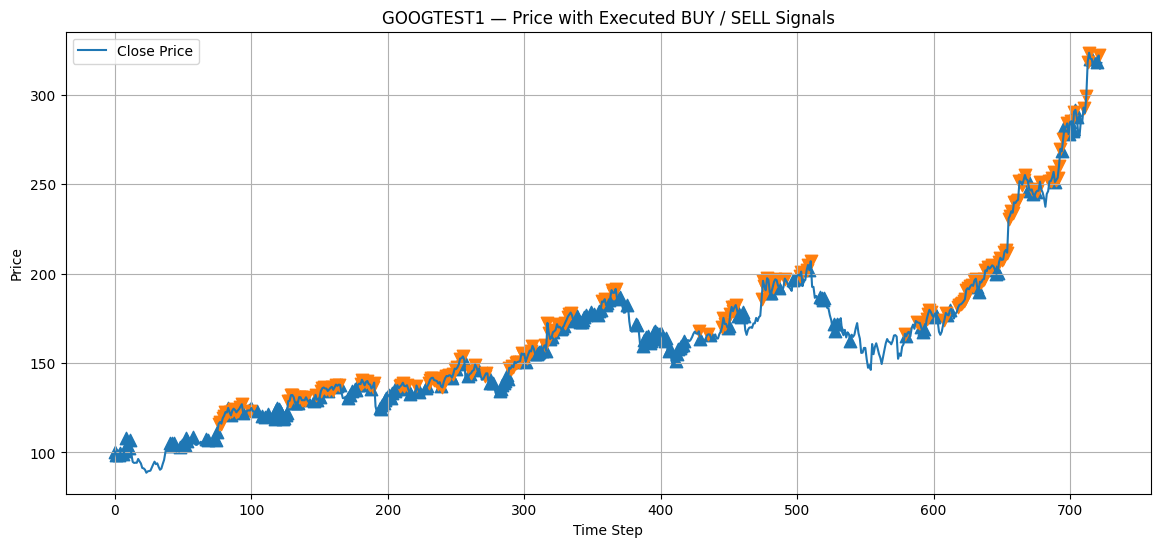

Final realized profit (GOOGTEST1): 18521.717445373535
Final balance: 28521.717445373535
Total BUYs: 242
Total SELLs: 210
Total HOLDs: 272
         Close  Signal Signal_Label
0   100.456558       1          BUY
1    98.471443       1          BUY
2    96.009903       0         HOLD
3    98.421829       1          BUY
4    99.960281       1          BUY
5    97.220825       0         HOLD
6    99.126526       1          BUY
7   100.674927       1          BUY
8   107.990059       1          BUY
9   104.436707       1          BUY
10  102.699738       1          BUY
11  107.235710       1          BUY
12   99.255569       0         HOLD
13   94.749359       0         HOLD
14   94.153824       0         HOLD
15   94.292786       0         HOLD
16   94.243156       0         HOLD
17   96.377151       0         HOLD
18   95.066978       0         HOLD
19   93.885834       0         HOLD
20   91.364754       0         HOLD
21   91.116608       0         HOLD
22   90.392059       0         HOL

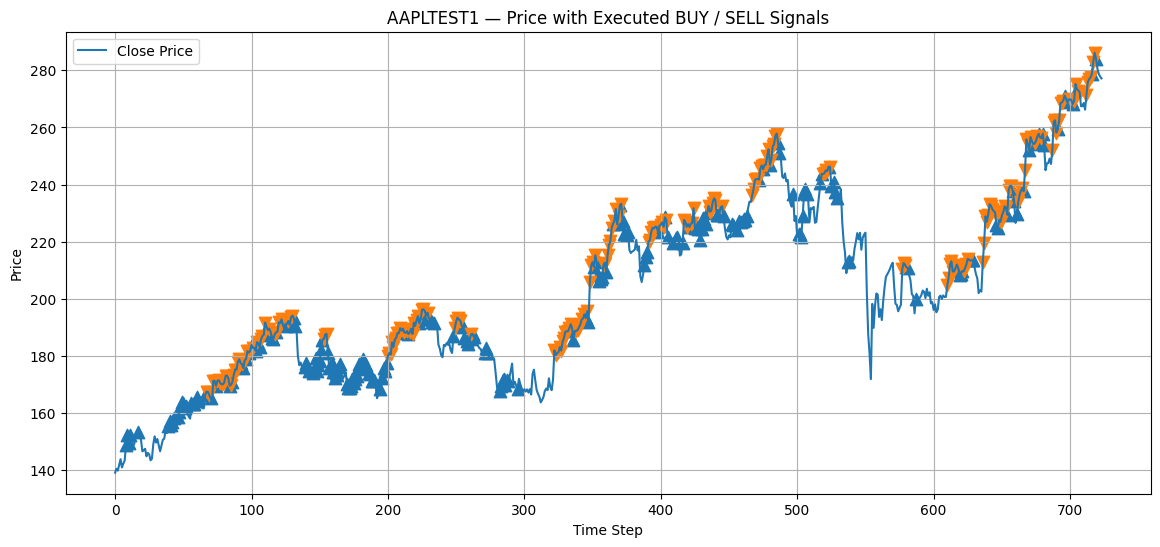

Final realized profit (AAPLTEST1): 6143.320175170895
Final balance: 16143.320175170895
Total BUYs: 244
Total SELLs: 212
Total HOLDs: 268
         Close  Signal Signal_Label
0   139.012802       0         HOLD
1   140.411728       0         HOLD
2   139.751663       0         HOLD
3   141.820465       0         HOLD
4   143.761185       0         HOLD
5   140.874725       0         HOLD
6   142.145569       0         HOLD
7   143.268631       0         HOLD
8   148.578506       1          BUY
9   152.203827       1          BUY
10  149.474976       1          BUY
11  152.351578       1          BUY
12  149.662186       0         HOLD
13  148.627762       0         HOLD
14  148.992828       0         HOLD
15  151.794891       0         HOLD
16  151.153580       0         HOLD
17  153.255112       1          BUY
18  151.656738       0         HOLD
19  150.512253       0         HOLD
20  146.496597       0         HOLD
21  146.920868       0         HOLD
22  147.404297       0         HOLD

In [38]:
actor = tf.keras.models.load_model("models/tech_stocks_alt.keras") #higher long term profit

test("GOOGTEST1", actor)
test("AAPLTEST1", actor)

In [110]:
#agent.actor.save("models/tech_stocks_alt.keras")

In [26]:
tickers = ["JPM", "WFC", "C", "BAC"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [28]:
agent = train(envs, tickers)

Episode 0 Profit -362.043762207031
Episode 1 Profit -406.67437744140705
Episode 2 Profit 296.6816787719712
Episode 3 Profit -1127.8748073577867
Episode 4 Profit 1663.096199035647
Episode 5 Profit 2809.1441459655784
Episode 6 Profit 988.8507766723644
Episode 7 Profit 1953.8083438873268
Episode 8 Profit 1073.4727783203132
Episode 9 Profit -1091.6838188171384
Episode 10 Profit 1767.2800292968734
Episode 11 Profit 1693.8941326141367
Episode 12 Profit 1225.0938873291022
Episode 13 Profit 144.02546691894523
Episode 14 Profit 814.1759948730471
Episode 15 Profit 1089.7902603149419
Episode 16 Profit 1080.9279174804703
Episode 17 Profit -330.1427040100093
Episode 18 Profit 228.45706939697237
Episode 19 Profit 1122.0241985321043
Episode 20 Profit 2237.2480621337895
Episode 21 Profit 4177.784336090087
Episode 22 Profit -596.601364135742
Episode 23 Profit 1900.277519226071
Episode 24 Profit 731.7436065673835
Episode 25 Profit 1507.6029930114732
Episode 26 Profit -980.3214988708503
Episode 27 Profit

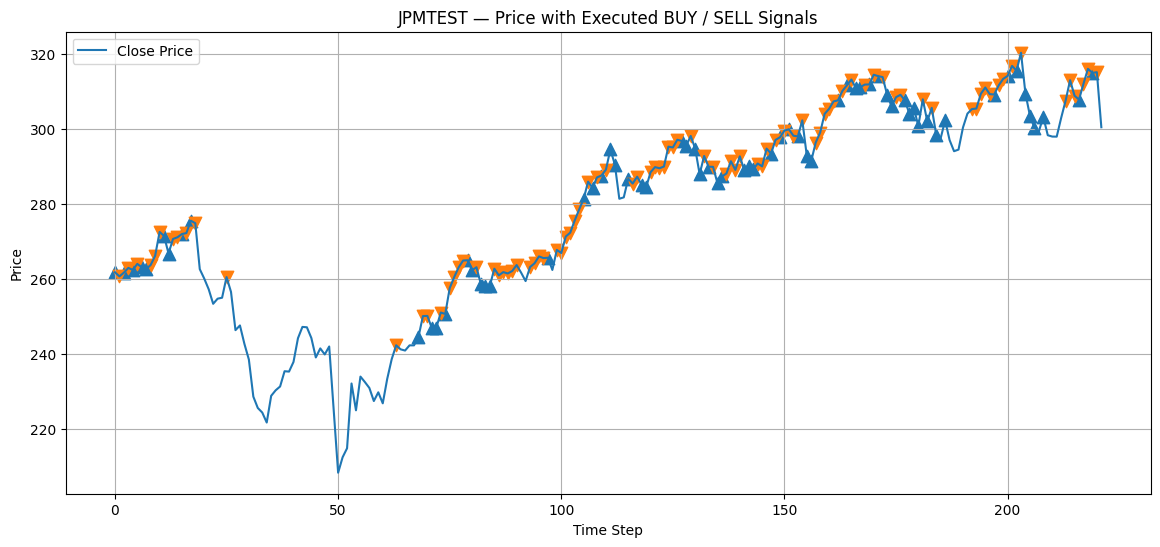

Final realized profit (JPMTEST): 1374.6027526855469
Final balance: 11374.602752685547
Total BUYs: 67
Total SELLs: 91
Total HOLDs: 64
         Close  Signal Signal_Label
0   261.781891       1          BUY
1   260.689301       2         SELL
2   261.683441       1          BUY
3   262.953247       2         SELL
4   262.401978       1          BUY
5   264.026154       2         SELL
6   263.110718       1          BUY
7   262.628387       1          BUY
8   263.740723       2         SELL
9   266.191650       2         SELL
10  272.560272       2         SELL
11  271.477509       1          BUY
12  266.792145       1          BUY
13  270.680176       2         SELL
14  271.133026       2         SELL
15  271.989380       1          BUY
16  272.255127       2         SELL
17  275.562500       1          BUY
18  274.873444       2         SELL
19  262.618561       0         HOLD
20  260.098663       0         HOLD
21  257.244141       0         HOLD
22  253.365891       0         HOLD
23 

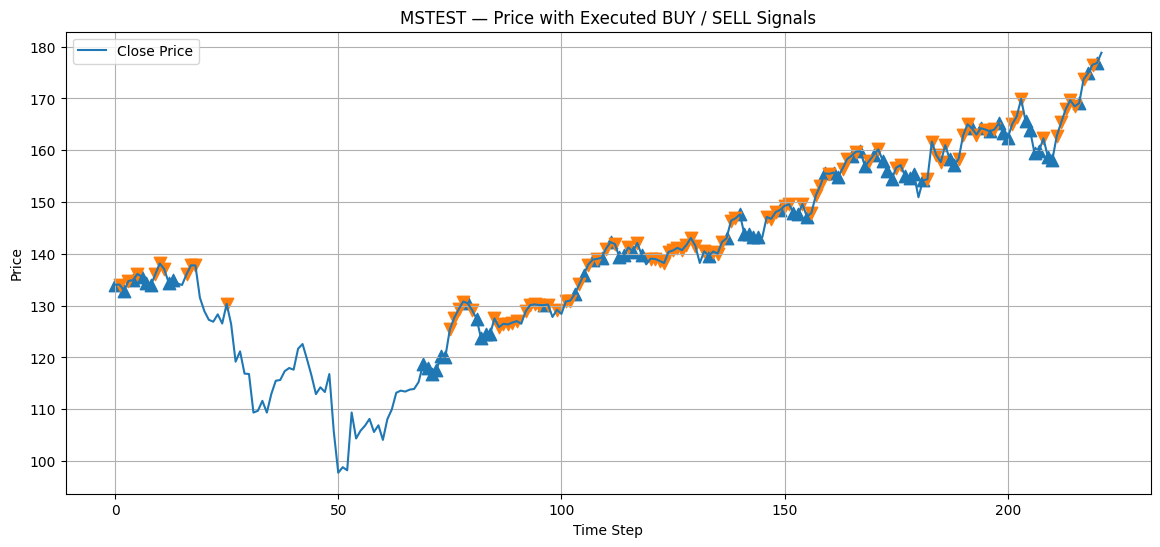

Final realized profit (MSTEST): 2639.567207336426
Final balance: 12639.567207336426
Total BUYs: 71
Total SELLs: 92
Total HOLDs: 59
         Close  Signal Signal_Label
0   134.046555       1          BUY
1   134.066010       2         SELL
2   132.927872       1          BUY
3   134.766373       2         SELL
4   134.931763       1          BUY
5   136.128265       2         SELL
6   135.555389       1          BUY
7   134.311768       1          BUY
8   133.929871       1          BUY
9   136.045029       2         SELL
10  138.150375       2         SELL
11  137.073212       2         SELL
12  134.458664       1          BUY
13  134.928696       1          BUY
14  134.262802       0         HOLD
15  133.998413       0         HOLD
16  136.064621       2         SELL
17  137.788071       2         SELL
18  137.768494       2         SELL
19  131.550323       0         HOLD
20  128.955368       0         HOLD
21  127.271080       0         HOLD
22  126.908760       0         HOLD
23  1

In [46]:
actor = tf.keras.models.load_model("models/finance_stocks.keras")

test("JPMTEST",actor)
test("MSTEST", actor)

In [36]:
#agent.actor.save("models/finance_stocks.keras")

In [81]:
tickers = ["AFRM", "UPST", "SOFI", "LC"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [82]:
agent = train(envs, tickers)

Episode 0 Profit 5655.420884132386
Episode 1 Profit 80.51954078674407
Episode 2 Profit 4987.065129756927
Episode 3 Profit 1930.2490043640128
Episode 4 Profit -5721.8101596832275
Episode 5 Profit -7307.3953342437735
Episode 6 Profit -382.6803331375122
Episode 7 Profit 23.297008514404524
Episode 8 Profit -5837.789394378661
Episode 9 Profit 392.2095699310289
Episode 10 Profit 276.9598445892334
Episode 11 Profit -301.15420532226557
Episode 12 Profit -178.5000190734877
Episode 13 Profit -3220.0088005065913
Episode 14 Profit 1331.5796651840192
Episode 15 Profit -1211.688331604004
Episode 16 Profit 922.2498722076411
Episode 17 Profit -7221.720056533813
Episode 18 Profit -409.80029249191284
Episode 19 Profit -2768.085289001465
Episode 20 Profit -968.2952117919924
Episode 21 Profit -8500.450233459473
Episode 22 Profit 5042.518939971927
Episode 23 Profit -766.3380393981931
Episode 24 Profit 16681.641337394714
Episode 25 Profit -3488.5547485351562
Episode 26 Profit 392.62026739120483
Episode 27 P

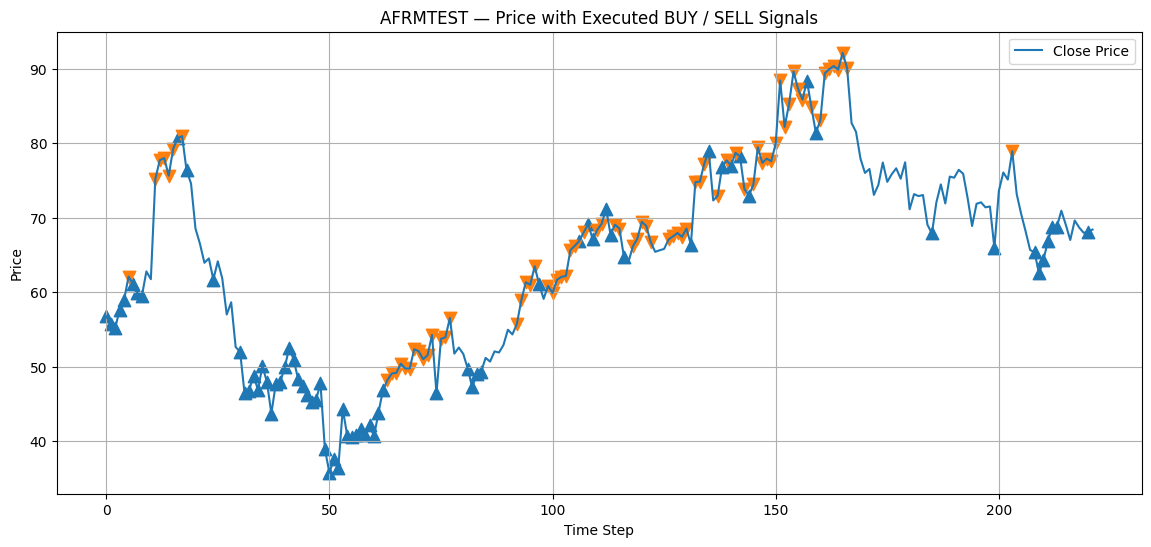

Final realized profit (AFRMTEST): 4464.419097900391
Final balance: 14464.41909790039
Total BUYs: 73
Total SELLs: 76
Total HOLDs: 73
        Close  Signal Signal_Label
0   56.759998       1          BUY
1   55.730000       1          BUY
2   55.169998       1          BUY
3   57.639999       1          BUY
4   58.950001       1          BUY
5   62.099998       2         SELL
6   61.070000       1          BUY
7   59.880001       1          BUY
8   59.529999       1          BUY
9   62.799999       0         HOLD
10  61.750000       0         HOLD
11  75.220001       2         SELL
12  77.750000       2         SELL
13  78.019997       2         SELL
14  75.660004       2         SELL
15  79.279999       2         SELL
16  80.690002       1          BUY
17  80.980003       2         SELL
18  76.379997       1          BUY
19  74.610001       0         HOLD
20  68.550003       0         HOLD
21  66.510002       0         HOLD
22  63.959999       0         HOLD
23  64.540001       0       

In [103]:
actor = tf.keras.models.load_model("models/fintech_stocks.keras") #chances of very high profits as well as very high losses depending on the stock

test("AFRMTEST", actor)

In [80]:
#agent.actor.save("models/fintech_stocks.keras")

In [92]:
tickers = ["V", "MA", "FIS", "FISV"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [93]:
agent = train(envs, tickers)

Episode 0 Profit 150.36047363281205
Episode 1 Profit 61.352111816408296
Episode 2 Profit 741.1484107971205
Episode 3 Profit 1542.258026123046
Episode 4 Profit 881.2543182373024
Episode 5 Profit 1808.5166320800804
Episode 6 Profit 2574.842372894288
Episode 7 Profit 2833.8702621459965
Episode 8 Profit 446.10606384277435
Episode 9 Profit 212.02246093749864
Episode 10 Profit 33.301795959472656
Episode 11 Profit 630.7908248901349
Episode 12 Profit 781.6400756835938
Episode 13 Profit 1268.2514953613309
Episode 14 Profit -1435.8217620849616
Episode 15 Profit 3865.069107055662
Episode 16 Profit 171.68144226073832
Episode 17 Profit 542.7384643554701
Episode 18 Profit 3535.7473411560068
Episode 19 Profit 443.2488861083973
Episode 20 Profit 452.01377868651946
Episode 21 Profit -558.0431213378905
Episode 22 Profit -1203.272621154785
Episode 23 Profit 1285.5599288940434
Episode 24 Profit 616.5204467773401
Episode 25 Profit 777.8670043945351
Episode 26 Profit 126.42747116088785
Episode 27 Profit 928

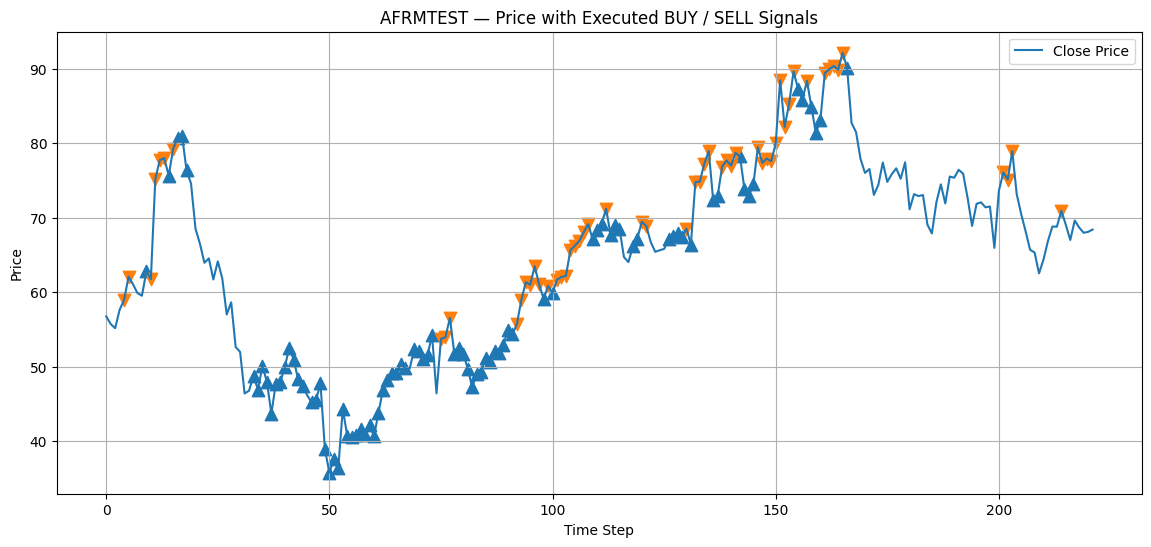

Final realized profit (AFRMTEST): 1531.154197692871
Final balance: 11531.154197692871
Total BUYs: 85
Total SELLs: 56
Total HOLDs: 81
        Close  Signal Signal_Label
0   56.759998       0         HOLD
1   55.730000       0         HOLD
2   55.169998       0         HOLD
3   57.639999       0         HOLD
4   58.950001       2         SELL
5   62.099998       2         SELL
6   61.070000       0         HOLD
7   59.880001       0         HOLD
8   59.529999       0         HOLD
9   62.799999       1          BUY
10  61.750000       2         SELL
11  75.220001       2         SELL
12  77.750000       2         SELL
13  78.019997       2         SELL
14  75.660004       1          BUY
15  79.279999       2         SELL
16  80.690002       1          BUY
17  80.980003       1          BUY
18  76.379997       1          BUY
19  74.610001       0         HOLD
20  68.550003       0         HOLD
21  66.510002       0         HOLD
22  63.959999       0         HOLD
23  64.540001       0      

In [104]:
actor = tf.keras.models.load_model("models/fintech_stocks_alt.keras") #more consistent across various stocks but lesser ovr profit can be expected

test("AFRMTEST", agent.actor)

In [105]:
#agent.actor.save("models/fintech_stocks_alt.keras")

In [107]:
tickers = ["PCAR", "F", "GM", "TSLA"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [108]:
agent = train(envs, tickers)

Episode 0 Profit 2224.2109832763654
Episode 1 Profit -279.2607526779168
Episode 2 Profit -662.4141044616695
Episode 3 Profit 933.1102294921905
Episode 4 Profit 3338.373229980468
Episode 5 Profit 1387.2692432403608
Episode 6 Profit 2116.9661903381343
Episode 7 Profit -2969.4408111572275
Episode 8 Profit 1684.8823127746582
Episode 9 Profit -949.4841995239256
Episode 10 Profit -1655.577230453491
Episode 11 Profit -1542.5329742431627
Episode 12 Profit 3730.800880432127
Episode 13 Profit -735.414294242858
Episode 14 Profit 2263.0275421142574
Episode 15 Profit -115.419921875
Episode 16 Profit 1380.472511291503
Episode 17 Profit 2197.7627658843994
Episode 18 Profit 1984.967275619507
Episode 19 Profit 3717.329216003417
Episode 20 Profit 3765.3328285217285
Episode 21 Profit -53.440809249877475
Episode 22 Profit 2169.3095779418954
Episode 23 Profit 4729.619110107422
Episode 24 Profit 1878.699848175048
Episode 25 Profit 714.4632720947241
Episode 26 Profit 2565.097724914554
Episode 27 Profit 3807.

In [ ]:
actor = tf.keras.models.load_model("models/auto_stocks.keras")
test("HMCTEST", actor)

In [12]:
#agent.actor.save("models/auto_stocks.keras")

In [111]:
tickers = ["XOM", "CVX", "COP", "EOG"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [112]:
agent = train(envs, tickers)

Episode 0 Profit 698.2530593872086
Episode 1 Profit 155.59439086914062
Episode 2 Profit 1694.1863479614271
Episode 3 Profit 74.1387786865273
Episode 4 Profit 446.1428833007799
Episode 5 Profit -218.4313507080078
Episode 6 Profit -1286.0141448974596
Episode 7 Profit 76.02872467041061
Episode 8 Profit 615.9192504882822
Episode 9 Profit -546.0080261230469
Episode 10 Profit 217.73094940185456
Episode 11 Profit 1211.7657623291018
Episode 12 Profit 437.3053588867174
Episode 13 Profit -70.82254791259766
Episode 14 Profit -63.366050720215526
Episode 15 Profit -258.89224243163596
Episode 16 Profit 584.5766220092762
Episode 17 Profit 172.84487915039062
Episode 18 Profit -451.828697204591
Episode 19 Profit -234.76051330566202
Episode 20 Profit -579.0070495605471
Episode 21 Profit 562.7535552978516
Episode 22 Profit 82.98954010009766
Episode 23 Profit -46.66368865966797
Episode 24 Profit -317.5488586425772
Episode 25 Profit 836.9016571044922
Episode 26 Profit -34.312408447261646
Episode 27 Profit 

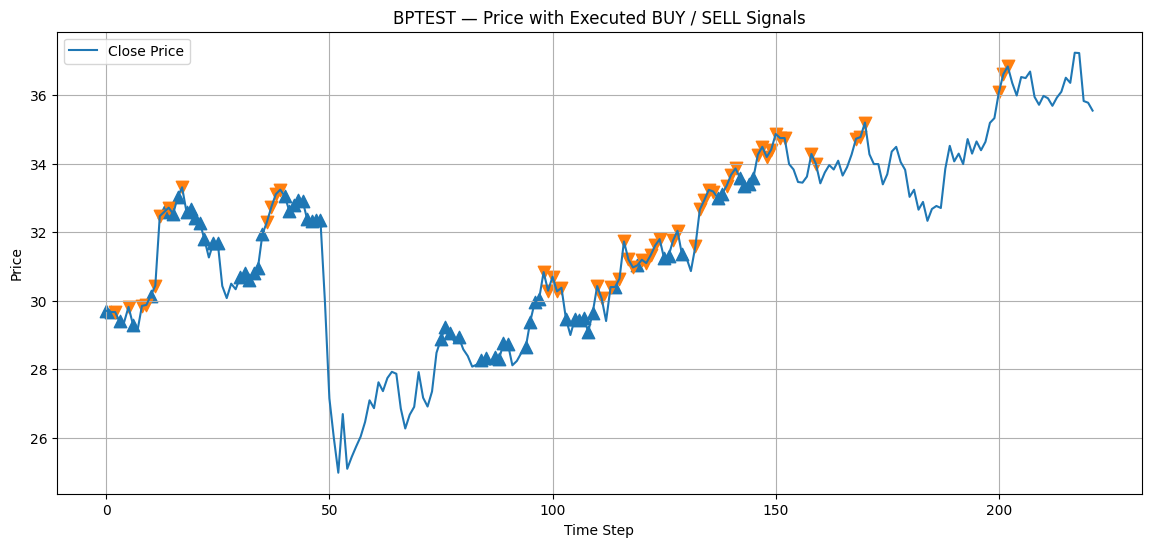

Final realized profit (BPTEST): 888.677568435669
Final balance: 10888.677568435669
Total BUYs: 61
Total SELLs: 54
Total HOLDs: 107
        Close  Signal Signal_Label
0   29.706650       1          BUY
1   29.668917       1          BUY
2   29.668917       2         SELL
3   29.395338       1          BUY
4   29.367039       0         HOLD
5   29.819859       2         SELL
6   29.301001       1          BUY
7   29.121763       0         HOLD
8   29.848156       2         SELL
9   29.876457       2         SELL
10  30.150034       1          BUY
11  30.442478       2         SELL
12  32.470718       2         SELL
13  32.593353       1          BUY
14  32.715992       2         SELL
15  32.536758       1          BUY
16  33.017876       1          BUY
17  33.310314       2         SELL
18  32.583923       1          BUY
19  32.687695       1          BUY
20  32.419838       1          BUY
21  32.276348       1          BUY
22  31.788473       1          BUY
23  31.262331       0        

In [113]:
test("BPTEST", agent.actor)

In [13]:
#agent.actor.save("models/energy_stocks.keras")

In [14]:
tickers = ["MU", "TXN", "QCOM", "NXPI"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [15]:
agent = train(envs, tickers)

I0000 00:00:1766043491.682670    2294 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Episode 0 Profit -1568.4201583862302
Episode 1 Profit 1641.5611419677734
Episode 2 Profit -302.91378021239905
Episode 3 Profit 292.9870605468749
Episode 4 Profit 2339.1902389526363
Episode 5 Profit 232.79127502441125
Episode 6 Profit 2164.467628479004
Episode 7 Profit 3831.5535430908203
Episode 8 Profit 1385.6524696350098
Episode 9 Profit 899.3801116943359
Episode 10 Profit 3602.273872375488
Episode 11 Profit 941.7279357910136
Episode 12 Profit 453.23590469360306
Episode 13 Profit -101.06430053710938
Episode 14 Profit 1622.094375610352
Episode 15 Profit -652.31393432617
Episode 16 Profit 2268.655307769773
Episode 17 Profit 954.8425445556641
Episode 18 Profit 267.10636901855685
Episode 19 Profit 940.4628448486316
Episode 20 Profit 360.266265869139
Episode 21 Profit 159.95066833496094
Episode 22 Profit 1169.5425720214846
Episode 23 Profit 758.8095550537105
Episode 24 Profit 3183.2527694702135
Episode 25 Profit 408.0122680664067
Episode 26 Profit -103.10571289062393
Episode 27 Profit 2434

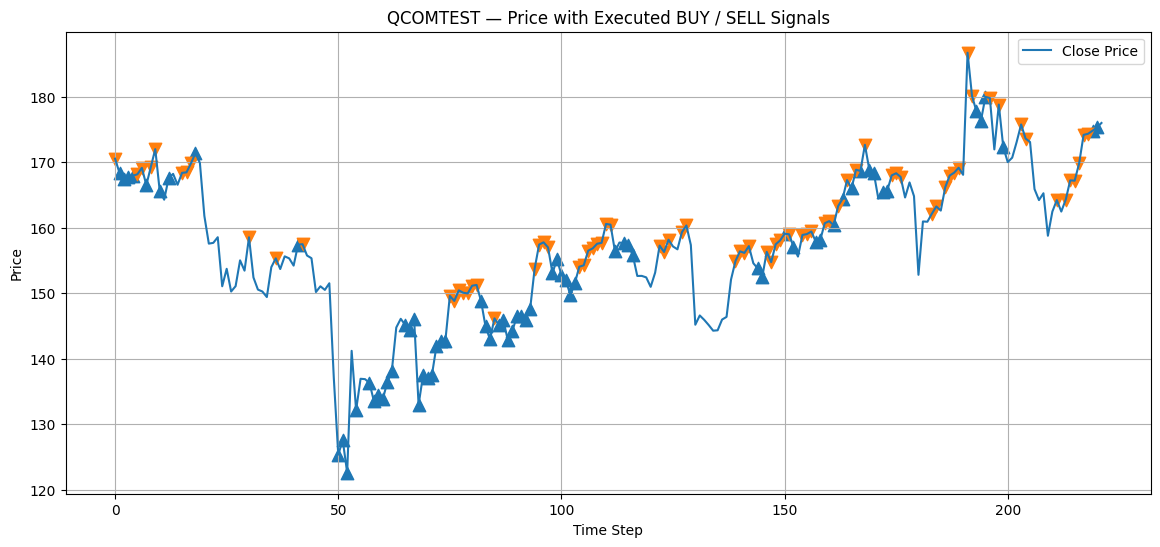

Final realized profit (QCOMTEST): 3013.2254180908203
Final balance: 13013.22541809082
Total BUYs: 70
Total SELLs: 76
Total HOLDs: 76
         Close  Signal Signal_Label
0   170.542435       2         SELL
1   168.341690       1          BUY
2   167.432037       1          BUY
3   167.793945       1          BUY
4   167.950470       1          BUY
5   168.165619       2         SELL
6   169.143723       2         SELL
7   166.512650       1          BUY
8   169.251328       2         SELL
9   172.009598       2         SELL
10  165.612793       1          BUY
11  164.282562       0         HOLD
12  167.608124       1          BUY
13  168.224335       0         HOLD
14  166.561523       0         HOLD
15  168.380829       2         SELL
16  168.459076       2         SELL
17  169.838196       2         SELL
18  171.383606       1          BUY
19  169.896881       0         HOLD
20  161.807968       0         HOLD
21  157.572754       0         HOLD
22  157.690140       0         HOLD
23 

In [18]:
actor = tf.keras.models.load_model("models/semiconductor_stocks.keras")
test("QCOMTEST", actor)

In [17]:
#agent.actor.save("models/semiconductor_stocks.keras")

In [20]:
tickers = ["LMT", "GD", "NOC", "LHX"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [21]:
agent = train(envs, tickers)

Episode 0 Profit 1074.1682739257817
Episode 1 Profit 367.90576171874807
Episode 2 Profit -151.85702514648517
Episode 3 Profit 285.2604217529297
Episode 4 Profit 483.0726318359382
Episode 5 Profit 236.09902954101722
Episode 6 Profit 1951.2234497070317
Episode 7 Profit 1485.2108612060536
Episode 8 Profit 244.8418884277345
Episode 9 Profit 433.5263366699221
Episode 10 Profit 4189.172271728516
Episode 11 Profit -242.20463562011628
Episode 12 Profit 1534.4434204101562
Episode 13 Profit 2790.0668792724605
Episode 14 Profit 1119.5499877929685
Episode 15 Profit 525.0393371582044
Episode 16 Profit -13.385345458984489
Episode 17 Profit -499.4878387451166
Episode 18 Profit 413.1325683593734
Episode 19 Profit 810.6799621582039
Episode 20 Profit 1366.5505065917969
Episode 21 Profit 162.54347229003724
Episode 22 Profit -284.57186889648494
Episode 23 Profit 306.4586181640618
Episode 24 Profit 43.197479248047614
Episode 25 Profit 201.08895874023415
Episode 26 Profit 3135.4153747558585
Episode 27 Profi

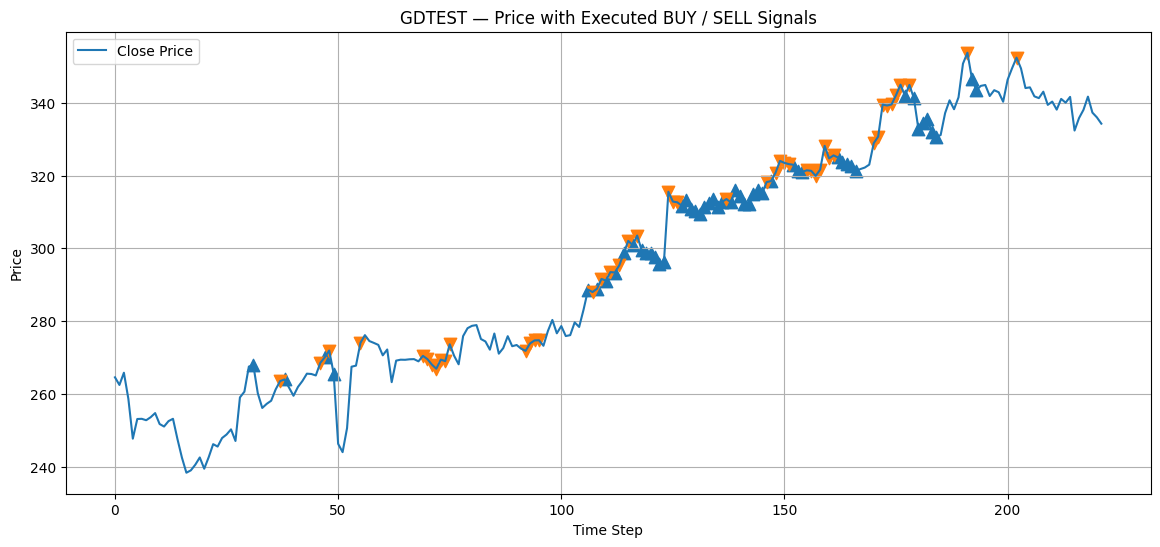

Final realized profit (GDTEST): 1572.3655395507812
Final balance: 11572.365539550781
Total BUYs: 52
Total SELLs: 47
Total HOLDs: 123
         Close  Signal Signal_Label
0   264.552185       0         HOLD
1   262.453949       0         HOLD
2   265.813080       0         HOLD
3   258.651550       0         HOLD
4   247.697525       0         HOLD
5   253.095718       0         HOLD
6   253.145004       0         HOLD
7   252.760803       0         HOLD
8   253.588257       0         HOLD
9   254.721100       0         HOLD
10  251.716629       0         HOLD
11  251.027084       0         HOLD
12  252.514526       0         HOLD
13  253.154831       0         HOLD
14  247.579315       0         HOLD
15  242.486465       0         HOLD
16  238.329437       0         HOLD
17  238.979599       0         HOLD
18  240.536011       0         HOLD
19  242.525864       0         HOLD
20  239.432724       0         HOLD
21  242.594818       0         HOLD
22  246.180511       0         HOLD
23 

In [28]:
actor = tf.keras.models.load_model("models/defence_stocks.keras")
test("GDTEST", actor)

In [25]:
#agent.actor.save('models/defence_stocks.keras')

In [29]:
tickers = ["CAT", "DE", "URI", "VMC"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [30]:
agent = train(envs, tickers)

Episode 0 Profit 1132.9612731933594
Episode 1 Profit 1250.6744995117188
Episode 2 Profit 2071.8963623046875
Episode 3 Profit 2102.720886230464
Episode 4 Profit 1996.633666992187
Episode 5 Profit 1278.2420959472645
Episode 6 Profit 1206.6640319824216
Episode 7 Profit -390.8804473876944
Episode 8 Profit 682.3347625732417
Episode 9 Profit 351.0272521972644
Episode 10 Profit 3959.3537292480455
Episode 11 Profit 1085.703552246092
Episode 12 Profit 943.5926513671877
Episode 13 Profit -67.36483764648636
Episode 14 Profit 2290.8649902343755
Episode 15 Profit 1571.0292358398378
Episode 16 Profit 4634.470916748045
Episode 17 Profit 1713.0586242675795
Episode 18 Profit 1240.078582763672
Episode 19 Profit 1382.1200561523435
Episode 20 Profit 825.8209533691422
Episode 21 Profit -677.7771911621089
Episode 22 Profit -1040.7646179199214
Episode 23 Profit 1559.2409362792926
Episode 24 Profit 1981.0915069580105
Episode 25 Profit 1049.5223083496126
Episode 26 Profit 1130.9602508544933
Episode 27 Profit 7

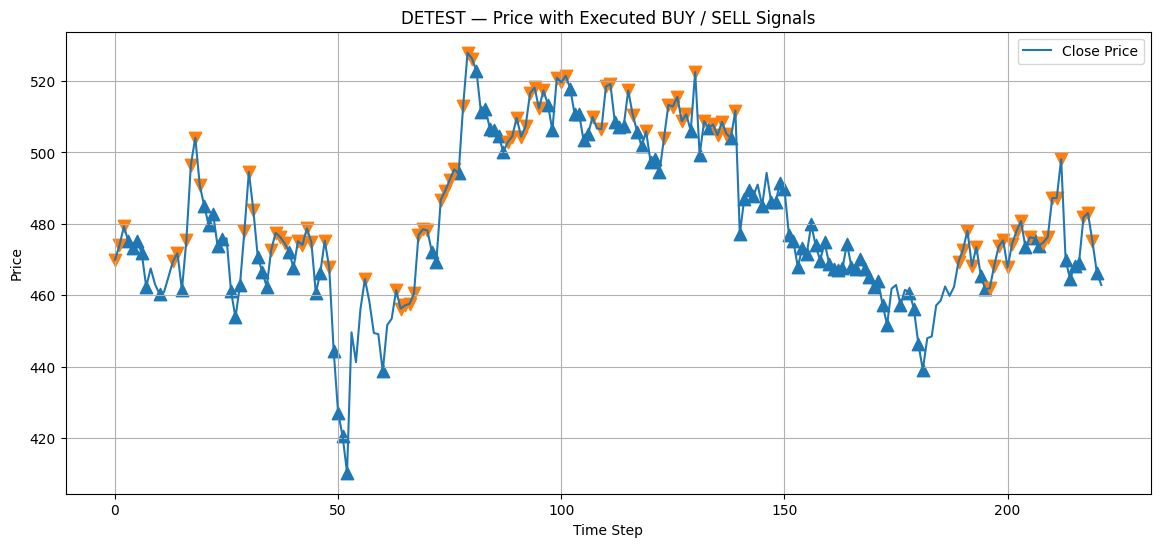

Final realized profit (DETEST): 1279.2607727050781
Final balance: 11279.260772705078
Total BUYs: 103
Total SELLs: 92
Total HOLDs: 27
         Close  Signal Signal_Label
0   469.933136       2         SELL
1   473.942291       2         SELL
2   479.268036       2         SELL
3   475.149994       1          BUY
4   473.338470       1          BUY
5   475.149994       1          BUY
6   471.754578       1          BUY
7   462.340454       1          BUY
8   467.507843       0         HOLD
9   462.964111       0         HOLD
10  460.291382       1          BUY
11  460.905090       0         HOLD
12  465.240967       0         HOLD
13  469.517365       2         SELL
14  471.754578       2         SELL
15  461.518860       1          BUY
16  475.377686       2         SELL
17  496.502502       2         SELL
18  504.134735       2         SELL
19  490.790680       2         SELL
20  485.039276       1          BUY
21  479.664032       1          BUY
22  482.673370       1          BUY
23 

In [13]:
actor = tf.keras.models.load_model("models/infra_stocks.keras")
test("DETEST", actor)

In [32]:
#agent.actor.save('models/infra_stocks.keras')

In [14]:
tickers = ["UPS", "FDX", "UNP", "CSX"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [15]:
agent = train(envs, tickers)

Episode 0 Profit 165.07260131835938
Episode 1 Profit 1462.812377929689
Episode 2 Profit 825.5844421386714
Episode 3 Profit -336.0198974609382
Episode 4 Profit -1401.3225021362305
Episode 5 Profit 271.4198608398452
Episode 6 Profit 18.176361083984375
Episode 7 Profit 218.50853157043383
Episode 8 Profit 690.5685729980469
Episode 9 Profit 1289.5838623046866
Episode 10 Profit 300.5314941406234
Episode 11 Profit -111.56163597106973
Episode 12 Profit 3032.49131011963
Episode 13 Profit -253.08288574219046
Episode 14 Profit -338.5820465087889
Episode 15 Profit 1102.7499542236337
Episode 16 Profit 945.1426849365218
Episode 17 Profit 4925.207580566412
Episode 18 Profit -319.6121978759778
Episode 19 Profit 533.4823036193875
Episode 20 Profit 399.5545196533203
Episode 21 Profit 4535.874755859373
Episode 22 Profit 579.5310363769518
Episode 23 Profit -48.186651229858626
Episode 24 Profit 1061.4589233398438
Episode 25 Profit 1058.2230377197234
Episode 26 Profit 1566.035736083984
Episode 27 Profit 198

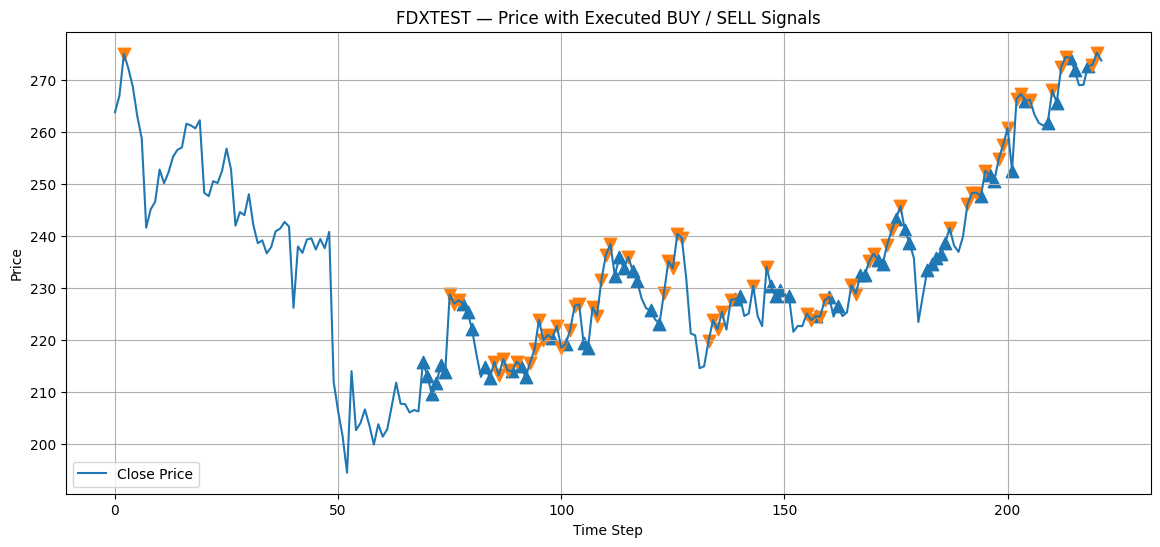

Final realized profit (FDXTEST): 2198.3204193115234
Final balance: 12198.320419311523
Total BUYs: 56
Total SELLs: 64
Total HOLDs: 102
         Close  Signal Signal_Label
0   263.788513       0         HOLD
1   266.973145       0         HOLD
2   275.022705       2         SELL
3   272.209229       0         HOLD
4   268.702209       0         HOLD
5   263.016754       0         HOLD
6   258.747772       0         HOLD
7   241.622955       0         HOLD
8   245.149506       0         HOLD
9   246.575760       0         HOLD
10  252.788757       0         HOLD
11  250.160919       0         HOLD
12  252.261246       0         HOLD
13  255.221207       0         HOLD
14  256.579041       0         HOLD
15  257.038208       0         HOLD
16  261.580719       0         HOLD
17  261.268127       0         HOLD
18  260.701508       0         HOLD
19  262.254791       0         HOLD
20  248.314621       0         HOLD
21  247.679626       0         HOLD
22  250.551697       0         HOLD
23

In [16]:
test("FDXTEST", agent.actor)

In [17]:
#agent.actor.save('models/logistics_stocks.keras')

In [20]:
tickers = ["CAT", "DE", "GE", "LMT"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [22]:
agent = train(envs, tickers)

Episode 0 Profit 1153.733673095705
Episode 1 Profit -43.31954956054665
Episode 2 Profit 2360.5482330322266
Episode 3 Profit 179.73181152343477
Episode 4 Profit 127.96478271484739
Episode 5 Profit 846.6816101074207
Episode 6 Profit 2244.318862915041
Episode 7 Profit 1513.0484924316388
Episode 8 Profit 575.5995330810576
Episode 9 Profit 496.7666625976561
Episode 10 Profit 3880.0778160095224
Episode 11 Profit 1275.945098876954
Episode 12 Profit 634.4254760742197
Episode 13 Profit 564.6156311035154
Episode 14 Profit 2951.6183853149414
Episode 15 Profit 862.5205688476535
Episode 16 Profit 1980.5036163330096
Episode 17 Profit 486.9687499999995
Episode 18 Profit 1063.8343353271441
Episode 19 Profit -314.47531127929756
Episode 20 Profit 2882.616180419921
Episode 21 Profit -156.81887817383057
Episode 22 Profit 4079.7906723022475
Episode 23 Profit 146.03698730468875
Episode 24 Profit 375.7317047119129
Episode 25 Profit -229.86206054687432
Episode 26 Profit 523.5517616271966
Episode 27 Profit 214

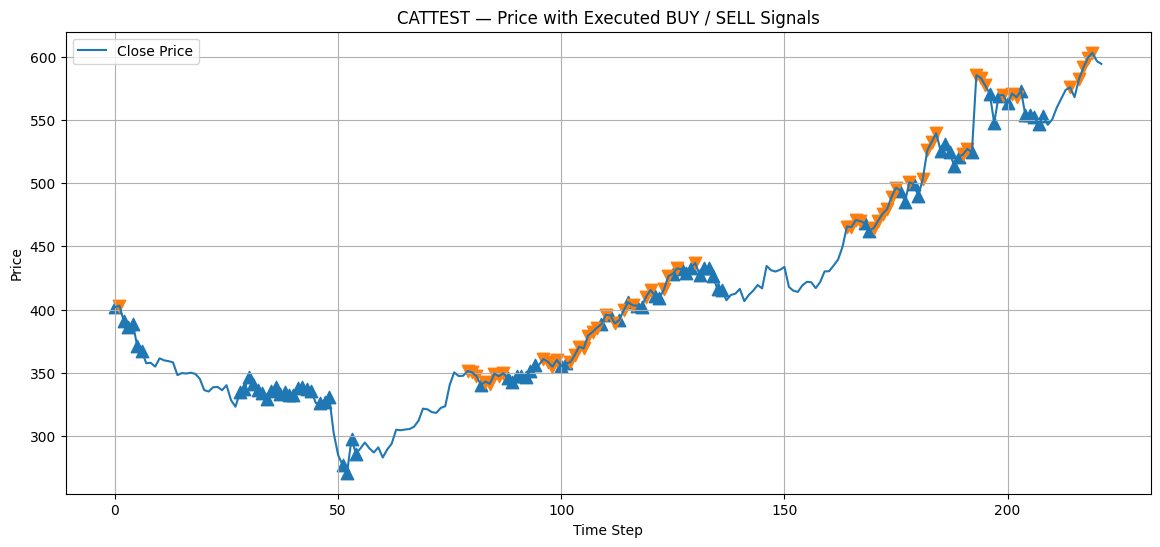

Final realized profit (CATTEST): 3788.6399841308594
Final balance: 13788.63998413086
Total BUYs: 80
Total SELLs: 58
Total HOLDs: 84
         Close  Signal Signal_Label
0   401.821899       1          BUY
1   403.038055       2         SELL
2   390.530579       1          BUY
3   385.893402       1          BUY
4   388.800323       1          BUY
5   370.755890       1          BUY
6   367.255737       1          BUY
7   357.477142       0         HOLD
8   357.872650       0         HOLD
9   354.807587       0         HOLD
10  361.333221       0         HOLD
11  359.780914       0         HOLD
12  359.128326       0         HOLD
13  358.149536       0         HOLD
14  348.074280       0         HOLD
15  349.715576       0         HOLD
16  349.339874       0         HOLD
17  350.012207       0         HOLD
18  349.023468       0         HOLD
19  345.216827       0         HOLD
20  336.209473       0         HOLD
21  335.102081       0         HOLD
22  338.503296       0         HOLD
23  

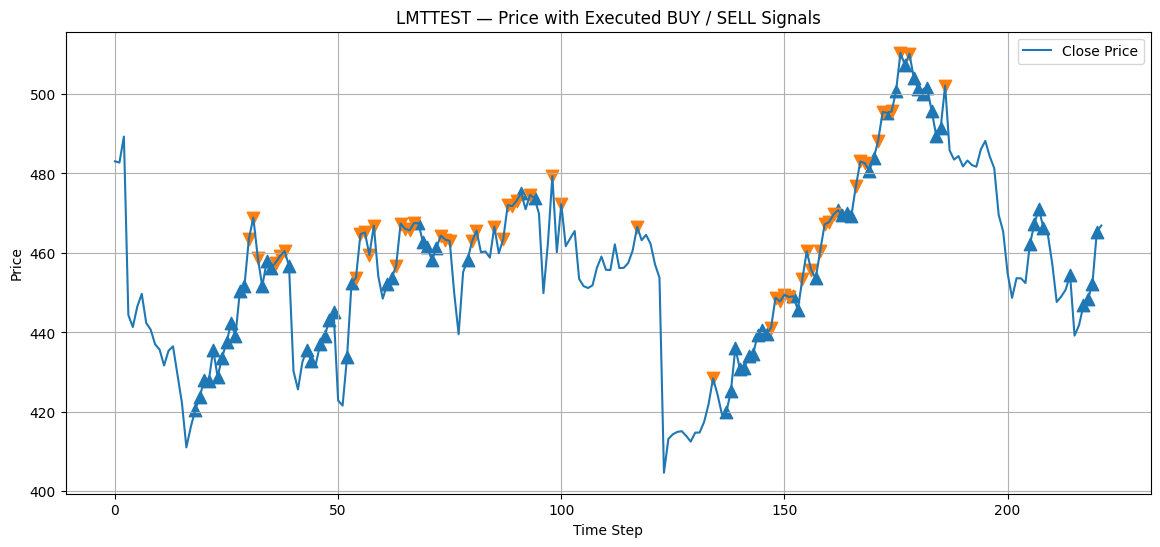

Final realized profit (LMTTEST): 2092.1339721679688
Final balance: 12092.133972167969
Total BUYs: 72
Total SELLs: 52
Total HOLDs: 98
         Close  Signal Signal_Label
0   483.041046       0         HOLD
1   482.730255       0         HOLD
2   489.267578       0         HOLD
3   444.351593       0         HOLD
4   441.350006       0         HOLD
5   446.488586       0         HOLD
6   449.694092       0         HOLD
7   442.379700       0         HOLD
8   440.689514       0         HOLD
9   436.988586       0         HOLD
10  435.677246       0         HOLD
11  431.665497       0         HOLD
12  435.385864       0         HOLD
13  436.493164       0         HOLD
14  429.314819       0         HOLD
15  422.272430       0         HOLD
16  411.072540       0         HOLD
17  416.269379       0         HOLD
18  420.553101       1          BUY
19  423.797424       1          BUY
20  428.100647       1          BUY
21  427.663483       1          BUY
22  435.618958       1          BUY
23 

In [23]:
test("CATTEST", agent.actor)
test("LMTTEST", agent.actor)

In [24]:
#agent.actor.save('models/industrial_stocks.keras')

In [32]:
tickers = ["JNJ", "BMY", "MRK", "PFE"]
envs = {t: TradingEnv(fetch_data(t)) for t in tickers}

In [33]:
agent = train(envs, tickers)

Episode 0 Profit -396.21937561035156
Episode 1 Profit -2152.6367416381836
Episode 2 Profit 303.0630722045893
Episode 3 Profit -1566.764451980591
Episode 4 Profit 1728.9178619384766
Episode 5 Profit 80.72895812988236
Episode 6 Profit 334.03990173340117
Episode 7 Profit 1076.5931911468501
Episode 8 Profit -238.01168823242188
Episode 9 Profit 1336.4409751892083
Episode 10 Profit 1509.4647064208984
Episode 11 Profit -2607.217630386352
Episode 12 Profit 469.35801696777344
Episode 13 Profit -180.74611282348656
Episode 14 Profit 1293.29397583008
Episode 15 Profit -1090.781957626342
Episode 16 Profit -631.7250061035156
Episode 17 Profit -2261.850318908691
Episode 18 Profit 2862.934280395507
Episode 19 Profit 282.59329986572243
Episode 20 Profit -222.8345947265625
Episode 21 Profit 361.65793228149414
Episode 22 Profit 1657.5762176513713
Episode 23 Profit -749.2788352966319
Episode 24 Profit 551.1538848876953
Episode 25 Profit 1989.9822921752948
Episode 26 Profit 1965.2741394042966
Episode 27 Pr

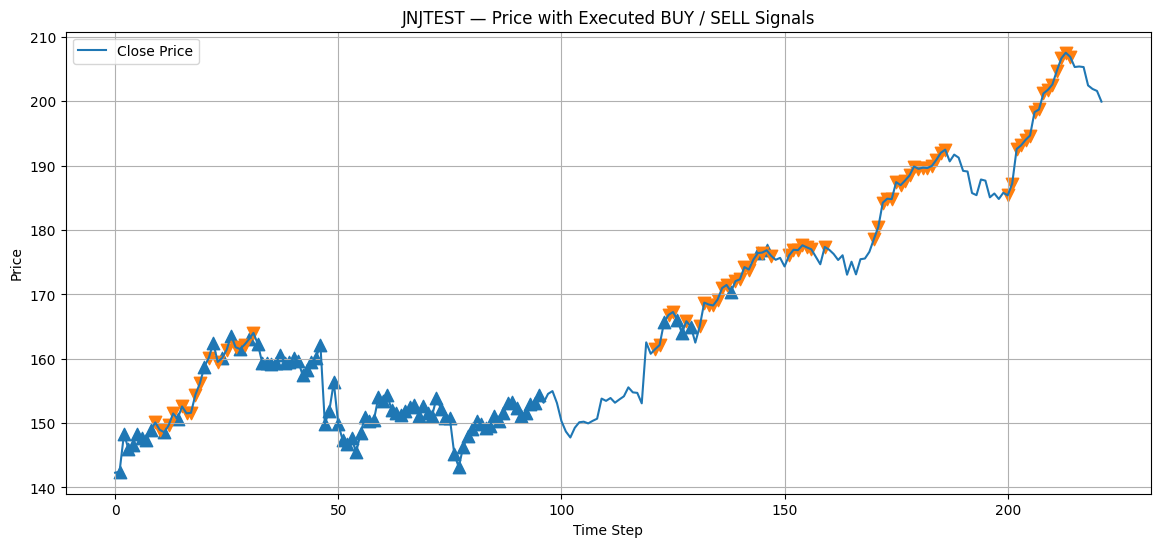

Final realized profit (JNJTEST): 1154.5867309570312
Final balance: 11154.586730957031
Total BUYs: 87
Total SELLs: 73
Total HOLDs: 62
         Close  Signal Signal_Label
0   142.284561       0         HOLD
1   142.459229       1          BUY
2   148.348938       1          BUY
3   145.913483       1          BUY
4   146.660599       1          BUY
5   148.329529       1          BUY
6   147.630920       1          BUY
7   147.359207       1          BUY
8   148.931122       1          BUY
9   150.095459       2         SELL
10  148.950500       2         SELL
11  148.572083       1          BUY
12  149.658829       2         SELL
13  151.492706       2         SELL
14  150.648544       1          BUY
15  152.579437       2         SELL
16  151.512115       2         SELL
17  151.590347       2         SELL
18  154.426743       2         SELL
19  156.177460       2         SELL
20  158.740021       1          BUY
21  160.148422       2         SELL
22  162.446884       1          BUY
23 

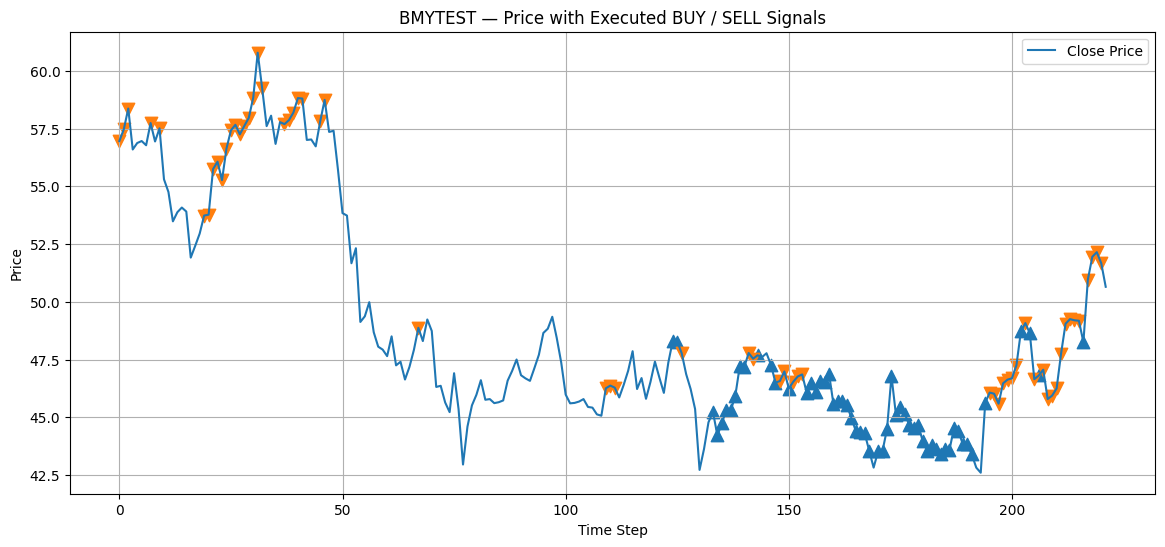

Final realized profit (BMYTEST): 842.8372192382812
Final balance: 10842.837219238281
Total BUYs: 56
Total SELLs: 60
Total HOLDs: 106
        Close  Signal Signal_Label
0   56.961388       2         SELL
1   57.471859       2         SELL
2   58.367599       2         SELL
3   56.595383       0         HOLD
4   56.874699       0         HOLD
5   56.961388       0         HOLD
6   56.778385       0         HOLD
7   57.741547       2         SELL
8   56.942120       0         HOLD
9   57.510387       2         SELL
10  55.304745       0         HOLD
11  54.755741       0         HOLD
12  53.484375       0         HOLD
13  53.879265       0         HOLD
14  54.081535       0         HOLD
15  53.908169       0         HOLD
16  51.914425       0         HOLD
17  52.424896       0         HOLD
18  52.954632       0         HOLD
19  53.734795       2         SELL
20  53.773323       2         SELL
21  55.747803       2         SELL
22  56.065643       2         SELL
23  55.266224       2      

In [34]:
test("JNJTEST", agent.actor)
test("BMYTEST", agent.actor)

In [35]:
agent.actor.save('models/pharma_stocks.keras')